# Modeling by Fire

### Table of Contents
- [Imports](#imports)
- [Data](#data)
- [Functions](#functions)
- [Models - Recent Tweets](#recent)
- [Models - Kincade](#kincade)
- [Models - Camp](#camp)
- [Models - Shasta](#shasta)
- [Models - Santa Rosa](#sr)
- [Models - Santa Barbara](#sb)

<a class="anchor" id="imports"></a>
## Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import TfidfVectorizer 
from gensim import corpora, models, similarities, matutils
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from sklearn.decomposition import LatentDirichletAllocation
from gsdmm import MovieGroupProcess
from collections import defaultdict
from sklearn.cluster import KMeans

In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/brittb28/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import spacy

<a class="anchor" id="data"></a>
## Data

In [5]:
with open('data/df_recent.pickle', 'rb') as read_file:
    df_recent = pickle.load(read_file)

In [4]:
with open('data/fire_clean.pickle', 'rb') as read_file:
    df_all = pickle.load(read_file)

In [5]:
df_all.shape

(234267, 12)

In [6]:
df_recent.shape

(6930, 9)

In [8]:
df_all.head()

,_id,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,fire
0,5dcb3fc81641db7377bb1e4e,,2018-09-19 16:59,4802,6465,large wildfire in california history officiall...,,,#,1.04256e+18,https://twitter.com/mdrtindia/status/104256384...,shasta_2018
1,5dcb3fc81641db7377bb1e4f,,2018-09-19 16:59,0,2,have -PRON- see the new nfpa ’s wildfire and f...,,,,1.04256e+18,https://twitter.com/JCFD3FireInfo/status/10425...,shasta_2018
2,5dcb3fc81641db7377bb1e50,,2018-09-19 16:59,7,8,rattlesnake creek fire unofficial wildfire upd...,,,,1.04256e+18,https://twitter.com/FireUnofficial/status/1042...,shasta_2018
3,5dcb3fc81641db7377bb1e51,,2018-09-19 16:57,0,1,wyoming ’s martencreekfire wildfire wyfire wyb...,,,# # # # #,1.04256e+18,https://twitter.com/RSFireNerd/status/10425634...,shasta_2018
4,5dcb3fc81641db7377bb1e52,,2018-09-19 16:56,0,0,honey cs video for numb drop soon queenhoneyc ...,,@,,1.04256e+18,https://twitter.com/HONEYCOCAINA_/status/10425...,shasta_2018


<a class="anchor" id="functions"></a>
## Functions

#### Vectorizers

In [10]:
def tfidf(documents):
    '''
    This function takes a corpus of documents. It computes a weighted term frequency by comaparing document frequency to 
    corpus frequency and placing weight on rare terms.
    -----------
    Inputs: List/Series of documents (strings)
    Outpus: sparse matrix, list, dictionary, model
    '''
    my_additional_stop_words = ['wildfire', 'like', 'pron']
    stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)
    cv_tfidf = TfidfVectorizer(analyzer = 'word',ngram_range = (2,3), min_df = 3, stop_words=stop_words, token_pattern = "\\b[a-z][a-z]+\\b") 
    doc_word = cv_tfidf.fit_transform(documents)
    words = cv_tfidf.get_feature_names()
    id2word = dict((v, k) for k, v in cv_tfidf.vocabulary_.items())
    return doc_word, words, id2word, cv_tfidf

In [11]:
def count_vec(documents):
    '''
    This function takes a corpus of documents and returns a sparse matrix mapping
    words and ngrams to documents. 
    Ex. ["This is a tweet", "Another tweet"]
                        This     is     a .   tweet .   another
    "This is a tweet"     1       1 .   1 .    1 .         0
    "Another tweet"       0 .     0 .   0 .    1 .         1
    
    --------------------------------
    Input: pd Series
    Output: Sparse Matrix
    '''
    # Adding additional stop words
    my_additional_stop_words = ['wildfire', 'like', 'pron']
    stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)
    vectorizer = CountVectorizer(ngram_range = (2,2), min_df = 3, max_df = 0.7, stop_words=stop_words, token_pattern = "\\b[a-z][a-z]+\\b")
    doc_word = vectorizer.fit_transform(documents)
    words = vectorizer.get_feature_names()
    id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())
    return doc_word, words

#### Topic Models = LSA, LDA, GSDMM

In [12]:
def dim_lsa(doc_word, no_topics):
    '''
    This function takes a sparse matrix map of documents to words and reduces the dimensions
    to topics. It uses SVD (singular value decomposition) to perform dimensional reduction on the 
    bag of words. Each row in the array has (no_topics) items in it.
    --------------------
    Inputs: sparse matrix, int
    Outputs: model, array, list
    '''
    lsa = TruncatedSVD(no_topics)
    doc_topic = lsa.fit_transform(doc_word)
    return lsa, doc_topic, lsa.explained_variance_ratio_

In [13]:
def sk_lda(doc_word, n_topics):
    '''
    This function takes a sparse matrix map of documents to words. It uses a dirchlet distribution to reduce
    dimensions using priors to inform topic "probabilities". Earch row in array has (no_topics) items in it.
    ------------------
    Inputs: sparse matrix, int
    Outputs: model, array, list
    '''
    lda = LatentDirichletAllocation(n_components=n_topics,random_state=0)
    doc_topic = lda.fit_transform(doc_word)
    return lda, doc_topic, lda.exp_dirichlet_component_

In [14]:
def gsdmm(tokens, n_terms):
    '''
    This function takes a list of lists (tokens). It reteurns a fit mgp model.
    tokens = tokenized documents
    n_terms = length of vocabulary in tokens
    --------------------
    Inputs: list of lists, int
    Outputs: model
    '''
    mgp = MovieGroupProcess(K=15, alpha=0.1, beta=0.1, n_iters=10)
    y = mgp.fit(tokens, n_terms)
    return mgp

#### Visualizing Topics

In [15]:
def display_topics(model, words, no_top_words, topic_names=None):
    '''
    This function takes a dim reduction model, words, number of words to display, and topic_names 
    (default= none). It returns strings of topics.
    ----------------
    Input: function, list, int
    Output: strs
    '''
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([words[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [16]:
def display_gsdmm(cluster_lst, documents, num_top_words=10, topic_names = None):
    '''
    This function displays the top bigrams and trigrams in each cluster found by gsdmm. 
    ---------------
    Inputs: model, list of lists (tokens), list, int
    Output: prints top topics
    '''
    
    dict_clusters = defaultdict(list)
    print(len(cluster_lst))
    print(len(documents))
    # Map the clusters to the documents they represent
    for i,v in enumerate(cluster_lst):
        dict_clusters[str(v)].append(documents[i])
    dict_counts = defaultdict(int)
    ix = 0
    
    # Use count vec to get word frequencies. Sum these up to get the most commonly occuring words in 
    # each cluster
    for key, value in dict_clusters.items():
        try:
            doc_word, words = count_vec(value)
            new = doc_word.toarray().sum(axis = 0)
        except:
            new = 'empty'
        if new == 'empty':
            print("\nTopic ", key)
        elif not topic_names or not topic_names[ix]:
            print("\nTopic ", key)
            print(", ".join([words[i]
                        for i in new.argsort()[:-num_top_words - 1:-1]]))
        else:
            print('\nTopic: {}'.format(topic_names[ix]))
            print(", ".join([words[i]
                        for i in new.argsort()[:-num_top_words - 1:-1]]))
        ix += 1

<a class="anchor" id="recent"></a>
## Models - All Tweets

In [17]:
df_recent.head()

,date,tweet,users,followers,location,emojis,hashtags,clean_tweet,tokens
0,2019-11-19 18:15:35,sad. because of this summer's wildfire and sub...,RyanBernhart_Wx,36,"Maricopa, AZ",None,None,sad summer wildfire subsequent flash flooding ...,"[sad, summer, wildfire, subsequent, flash, flo..."
1,2019-11-19 18:15:16,huge flow country wildfire 'doubled #scotland'...,CWL_BeGreen,1043,NaN,None,[(36:45) => #scotland],huge flow country wildfire doubled emissions m...,"[huge, flow, country, wildfire, doubled, emiss..."
2,2019-11-19 18:14:42,suburban sprawl and climate change complicate ...,babday,2,NaN,None,None,suburban sprawl climate change complicate wild...,"[suburban, sprawl, climate, change, complicate..."
3,2019-11-19 18:13:39,"in 2018, over 8 million acres were burned by w...",FavaFinancialGr,188,"Totowa, New Jersey",None,None,2018 8 million acres burned wildfire working a...,"[2018, 8, million, acres, burned, wildfire, wo..."
4,2019-11-19 18:13:36,california’s wildfire policy totally backfired...,NonsenseFinder,341,USA,None,None,california wildfire policy totally backfired n...,"[california, wildfire, policy, totally, backfi..."


In [20]:
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import string
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

In [23]:
stop_words.add('wildfire')

In [136]:
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    # Remove mentions, hashtags, urls
    mytokens = [word for word in mytokens if '$' not in word]
    
    # Remove '...'
    mytokens = [word for word in mytokens if '…' not in word]

    # return preprocessed list of tokens
    return mytokens

In [137]:
df_all['clean_tweet'] = [' '.join(spacy_tokenizer(tweet)) for tweet in df_all['text']]

In [138]:
other_new = []
for tweet in df_all['clean_tweet']:
    if 'wildfire' in tweet:
        tweet = tweet.replace('wildfire', '')
    if 'like' in tweet:
        tweet = tweet.replace('like', '')
    if '-pron-' in tweet:
        tweet = tweet.replace('-pron-', '')
    other_new.append(tweet)
df_all['clean_tweet'] = other_new

In [139]:
df_all['bigrams'] = [[gram for gram in nltk.ngrams(tweet.split(), 2)] for tweet in df_all['clean_tweet']]

In [140]:
df_all['tokens'] = [tweet.split(' ') for tweet in df_all['clean_tweet']]

In [141]:
df_all.head()

,_id,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,fire,clean_tweet,bigrams,tokens
0,5dcb3fc81641db7377bb1e4e,,2018-09-19 16:59,4802,6465,large wildfire in california history officiall...,,,#,1.04256e+18,https://twitter.com/mdrtindia/status/104256384...,shasta_2018,large california history officially contain,"[(large, california), (california, history), (...","[large, , california, history, officially, con..."
1,5dcb3fc81641db7377bb1e4f,,2018-09-19 16:59,0,2,have -PRON- see the new nfpa ’s wildfire and f...,,,,1.04256e+18,https://twitter.com/JCFD3FireInfo/status/10425...,shasta_2018,new nfpa firewise usa programs community wes...,"[(new, nfpa), (nfpa, firewise), (firewise, usa...","[, new, nfpa, , firewise, usa, programs, commu..."
2,5dcb3fc81641db7377bb1e50,,2018-09-19 16:59,7,8,rattlesnake creek fire unofficial wildfire upd...,,,,1.04256e+18,https://twitter.com/FireUnofficial/status/1042...,shasta_2018,rattlesnake creek fire unofficial update acre...,"[(rattlesnake, creek), (creek, fire), (fire, u...","[rattlesnake, creek, fire, unofficial, , updat..."
3,5dcb3fc81641db7377bb1e51,,2018-09-19 16:57,0,1,wyoming ’s martencreekfire wildfire wyfire wyb...,,,# # # # #,1.04256e+18,https://twitter.com/RSFireNerd/status/10425634...,shasta_2018,wyoming martencreekfire wyfire wybtf intterra,"[(wyoming, martencreekfire), (martencreekfire,...","[wyoming, martencreekfire, , wyfire, wybtf, in..."
4,5dcb3fc81641db7377bb1e52,,2018-09-19 16:56,0,0,honey cs video for numb drop soon queenhoneyc ...,,@,,1.04256e+18,https://twitter.com/HONEYCOCAINA_/status/10425...,shasta_2018,honey cs video numb drop soon queenhoneyc stre...,"[(honey, cs), (cs, video), (video, numb), (num...","[honey, cs, video, numb, drop, soon, queenhone..."


In [27]:
doc_word, words = count_vec(df_all['clean_tweet'])

In [28]:
n_terms = len(words)

In [31]:
mgp = gsdmm(df_all['tokens'], n_terms)

In stage 0: transferred 209660 clusters with 15 clusters populated
In stage 1: transferred 152149 clusters with 15 clusters populated
In stage 2: transferred 74297 clusters with 15 clusters populated
In stage 3: transferred 47717 clusters with 15 clusters populated
In stage 4: transferred 39625 clusters with 15 clusters populated
In stage 5: transferred 36863 clusters with 15 clusters populated
In stage 6: transferred 34881 clusters with 15 clusters populated
In stage 7: transferred 33984 clusters with 15 clusters populated
In stage 8: transferred 33374 clusters with 15 clusters populated
In stage 9: transferred 32921 clusters with 15 clusters populated


In [32]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)
print('*'*20)
# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-15:][::-1]
print('Most important clusters (by number of docs inside):', top_index)
print('*'*20)

Number of documents per topic : [ 3197 40906  2506 25737  3438  1472  4099 22552 14734 18135 15763 17999
 16892 23305 23532]
********************
Most important clusters (by number of docs inside): [ 1  3 14 13  7  9 11 12 10  8  6  4  0  2  5]
********************


In [60]:
import operator

**Display Top Words**

In [63]:
for i, topic in enumerate(mgp.cluster_word_distribution):
    sorted_x = sorted(topic.items(), key=operator.itemgetter(1), reverse = True)
    print('\n Topic: {}'.format(i))
    print(sorted_x[:10])


 Topic: 0
[('de', 1029), ('-pron-', 454), ('que', 442), ('space', 392), ('en', 329), ('la', 323), ('station', 310), ('nasa', 302), ('y', 262), ('california', 259)]

 Topic: 1
[('-pron-', 72316), ('like', 11649), ('spread', 6253), ('california', 4173), ('’', 3127), ('people', 2990), ('know', 2736), ('start', 2665), ('fire', 2383), ('think', 2269)]

 Topic: 2
[('。', 894), ('fire', 866), ('！', 375), ('information', 315), ('update', 285), ('ridge', 273), ('brazil', 208), ('？', 202), ('incident', 163), ('、', 161)]

 Topic: 3
[('-pron-', 32142), ('california', 12182), ('trump', 6956), ('state', 2688), ('people', 2304), ('forest', 2105), ('help', 2097), ('fire', 1936), ('blame', 1715), ('like', 1688)]

 Topic: 4
[('youtube', 1131), ('california', 1094), ('video', 752), ('-pron-', 509), ('like', 442), ('playlist', 300), ('climate', 282), ('add', 268), ('blame', 264), ('change', 255)]

 Topic: 5
[('california', 367), ('event', 350), ('think', 346), ('occur', 342), ('cdt', 341), ('oct', 267), (

## Shasta

In [14]:
with open('data/shasta_2018_5000.pickle', 'rb') as read_file:
    df_shasta_1 = pickle.load(read_file)

In [15]:
with open('data/shasta_2018_5001.pickle', 'rb') as read_file:
    df_shasta_2 = pickle.load(read_file)

In [16]:
df_shasta = pd.concat([df_shasta_1, df_shasta_2], axis = 0)

In [42]:
my_additional_stop_words = ['wildfire', 'like', '-pron-']
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

In [43]:
clean = []
for tweet in df_shasta['spell_trans']:
    word_tokens = nltk.word_tokenize(str(tweet).lower())
    filtered_sentence = [w for w in word_tokens if w not in stop_words]  
    sentence = ' '.join(filtered_sentence)
    clean.append(sentence)
df_shasta['clean'] = clean

In [44]:
df_shasta['bigrams'] = [[gram for gram in nltk.ngrams(tweet.split(), 2)] for tweet in df_shasta['clean']]

In [45]:
df_shasta['tokens'] = [tweet.split(' ') for tweet in df_shasta['clean']]

In [46]:
df_shasta.head()

,_id,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,fire,sentiment,sent_num,language,spell_trans,clean,bigrams,tokens
0,5dcb3fc81641db7377bb1e4e,,2018-09-19 16:59,4802,6465,large wildfire in california history officiall...,,,#,1.04256e+18,https://twitter.com/mdrtindia/status/104256384...,shasta_2018,positive,0.214286,en,large wildlife in california history officiall...,large wildlife california history officially c...,"[(large, wildlife), (wildlife, california), (c...","[large, wildlife, california, history, officia..."
1,5dcb3fc81641db7377bb1e4f,,2018-09-19 16:59,0,2,have -PRON- see the new nfpa ’s wildfire and f...,,,,1.04256e+18,https://twitter.com/JCFD3FireInfo/status/10425...,shasta_2018,positive,0.214545,en,have -PRON- see the new papa ’s wildlife and l...,new papa ’ s wildlife likewise programs commun...,"[(new, papa), (papa, ’), (’, s), (s, wildlife)...","[new, papa, ’, s, wildlife, likewise, programs..."
2,5dcb3fc81641db7377bb1e50,,2018-09-19 16:59,7,8,rattlesnake creek fire unofficial wildfire upd...,,,,1.04256e+18,https://twitter.com/FireUnofficial/status/1042...,shasta_2018,neutral,0.000000,en,rattlesnake creek fire unofficial wildlife upd...,rattlesnake creek unofficial wildlife update a...,"[(rattlesnake, creek), (creek, unofficial), (u...","[rattlesnake, creek, unofficial, wildlife, upd..."
3,5dcb3fc81641db7377bb1e51,,2018-09-19 16:57,0,1,wyoming ’s martencreekfire wildfire wyfire wyb...,,,# # # # #,1.04256e+18,https://twitter.com/RSFireNerd/status/10425634...,shasta_2018,neutral,0.000000,en,wyoming ’s martencreekfire wildlife fire wyeth...,wyoming ’ s martencreekfire wildlife wyeth int...,"[(wyoming, ’), (’, s), (s, martencreekfire), (...","[wyoming, ’, s, martencreekfire, wildlife, wye..."
4,5dcb3fc81641db7377bb1e52,,2018-09-19 16:56,0,0,honey cs video for numb drop soon queenhoneyc ...,,@,,1.04256e+18,https://twitter.com/HONEYCOCAINA_/status/10425...,shasta_2018,negative,-0.354545,en,honey is video for numb drop soon queenhoneyc ...,honey video numb drop soon queenhoneyc stream ...,"[(honey, video), (video, numb), (numb, drop), ...","[honey, video, numb, drop, soon, queenhoneyc, ..."


In [50]:
doc_word, words = count_vec(df_shasta['clean'])

In [52]:
n_terms = len(words)

In [54]:
mgp = gsdmm(df_shasta['bigrams'], n_terms)

In stage 0: transferred 8034 clusters with 15 clusters populated
In stage 1: transferred 4782 clusters with 15 clusters populated
In stage 2: transferred 4009 clusters with 15 clusters populated
In stage 3: transferred 3731 clusters with 15 clusters populated
In stage 4: transferred 3565 clusters with 15 clusters populated
In stage 5: transferred 3466 clusters with 15 clusters populated
In stage 6: transferred 3430 clusters with 15 clusters populated
In stage 7: transferred 3327 clusters with 15 clusters populated
In stage 8: transferred 3330 clusters with 15 clusters populated
In stage 9: transferred 3243 clusters with 15 clusters populated


In [55]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)
print('*'*20)
# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-15:][::-1]
print('Most important clusters (by number of docs inside):', top_index)
print('*'*20)

Number of documents per topic : [681 691 609 746 627 700 627 701 624 696 660 615 655 694 646]
********************
Most important clusters (by number of docs inside): [ 3  7  5  9 13  1  0 10 12 14  6  4  8 11  2]
********************


In [57]:
import operator

In [58]:
for i, topic in enumerate(mgp.cluster_word_distribution):
    sorted_x = sorted(topic.items(), key=operator.itemgetter(1), reverse = True)
    print('\n Topic: {}'.format(i))
    print(sorted_x[:20])


 Topic: 0
[(('spread', 'wildlife'), 125), (('california', 'wildlife'), 34), (('wildlife', 'smoke'), 33), (('sugar', 'creek'), 29), (('wildlife', '…'), 26), (('creek', 'lose'), 17), (('creek', 'wildlife'), 14), (('air', 'quality'), 13), (('…', 'incised'), 13), (('bc', 'wildlife'), 13), (('ca', 'wildlife'), 13), (('burn', 'wildlife'), 13), (('michael', 'martin'), 12), (('martin', 'murphy'), 12), (('…', '…'), 11), (('’', 's'), 11), (('north', 'america'), 11), (('horizon', 'throttle'), 11), (('die', 'wildlife'), 11), (('british', 'columbia'), 11)]

 Topic: 1
[(('west', 'coast'), 67), (('east', 'coast'), 42), (('wildlife', '…'), 39), (('coast', 'wildlife'), 38), (('wildlife', 'affect'), 36), (('wildlife', 'west'), 35), (('’', 's'), 30), (('aftermath', 'wildlife'), 29), (('capture', 'aftermath'), 28), (('wildlife', 'france'), 28), (('rings', 'lonely'), 25), (('affect', 'taste'), 21), (('taste', 'wine'), 21), (('natural', 'disaster'), 20), (('wildlife', 'earthquake'), 17), (('pp', 'pp'), 17)

## NCA 

In [59]:
with open('data/nca_2017_5000.pickle', 'rb') as read_file:
    nca_2017 = pickle.load(read_file)

In [60]:
my_additional_stop_words = ['wildfire', 'like', '-pron-']
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

In [61]:
clean = []
for tweet in nca_2017['spell_trans']:
    word_tokens = nltk.word_tokenize(str(tweet).lower())
    filtered_sentence = [w for w in word_tokens if w not in stop_words]  
    sentence = ' '.join(filtered_sentence)
    clean.append(sentence)
nca_2017['clean'] = clean

In [62]:
nca_2017['bigrams'] = [[gram for gram in nltk.ngrams(tweet.split(), 2)] for tweet in nca_2017['clean']]

In [63]:
nca_2017['tokens'] = [tweet.split(' ') for tweet in nca_2017['clean']]

In [64]:
doc_word, words = count_vec(nca_2017['clean'])

In [65]:
n_terms = len(words)

In [66]:
n_terms

1996

In [67]:
mgp = gsdmm(nca_2017['bigrams'], n_terms)

In stage 0: transferred 4012 clusters with 15 clusters populated
In stage 1: transferred 2010 clusters with 15 clusters populated
In stage 2: transferred 1654 clusters with 15 clusters populated
In stage 3: transferred 1536 clusters with 15 clusters populated
In stage 4: transferred 1479 clusters with 15 clusters populated
In stage 5: transferred 1490 clusters with 15 clusters populated
In stage 6: transferred 1469 clusters with 15 clusters populated
In stage 7: transferred 1480 clusters with 15 clusters populated
In stage 8: transferred 1454 clusters with 15 clusters populated
In stage 9: transferred 1434 clusters with 15 clusters populated


In [68]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)
print('*'*20)
# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-15:][::-1]
print('Most important clusters (by number of docs inside):', top_index)
print('*'*20)

Number of documents per topic : [385 353 300 321 323 304 325 355 319 322 311 367 371 315 328]
********************
Most important clusters (by number of docs inside): [ 0 12 11  7  1 14  6  4  9  3  8 13 10  5  2]
********************


In [69]:
import operator

In [70]:
for i, topic in enumerate(mgp.cluster_word_distribution):
    sorted_x = sorted(topic.items(), key=operator.itemgetter(1), reverse = True)
    print('\n Topic: {}'.format(i))
    print(sorted_x[:20])


 Topic: 0
[(('california', 'wildlife'), 219), (('wildlife', '…'), 54), (('burn', 'california'), 36), (('farm', 'burn'), 34), (('pot', 'farm'), 29), (('wildlife', 'victim'), 25), (('burn', 'home'), 22), (('victim', 'search'), 20), (('search', 'burn'), 20), (('home', 'memory'), 20), (('wildlife', 'threat'), 19), (('santa', 'ana'), 17), (('record', 'heat'), 16), (('heat', 'fierce'), 16), (('ana', 'wind'), 16), (('fuel', 'wildlife'), 16), (('fierce', 'santa'), 15), (('threat', 'california'), 15), (('doctor', 'brave'), 15), (('brave', 'wildlife'), 15)]

 Topic: 1
[(('california', 'wildlife'), 125), (('vineyards', 'worker'), 76), (('worker', 'owner'), 73), (('wildlife', '…'), 63), (('start', 'california'), 54), (('arrest', 'start'), 49), (('wildlife', 'affect'), 44), (('muslin', 'ran'), 39), (('affect', 'vineyards'), 39), (('illegal', 'muslin'), 38), (('ran', 'arrest'), 38), (('plunge', 'vineyards'), 33), (('owner', 'struggle'), 33), (('forgive', 'wildlife'), 30), (('break', 'illegal'), 29)

In [73]:
display_gsdmm(mgp, nca_2017['clean'], 10)

4999
4999

Topic  0
california wildlife, wildlife scotch, marijuana crop, scotch marijuana, possibly complicate, crop possibly, complicate california, california roylott, northern california, roylott legal

Topic  5
california wildlife, spread wildlife, northern california, wildlife burn, wildlife california, wildlife victim, climate change, vineyards worker, worker owner, wildlife relief


/Users/brittb28/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/brittb28/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [78]:
nca_2017['preds'] = [mgp.choose_best_label(x)[0] for x in nca_2017['clean']]

In [79]:
nca_2017.head()

,_id,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,fire,sentiment,sent_num,language,spell_trans,clean,bigrams,tokens,preds
0,5dcb401b1641db7377bda6e1,,2017-10-23 02:18,1,0,french authority get corsica wildfire under co...,,,#,9.22392e+17,https://twitter.com/PtCharlotteHelp/status/922...,nca_2017,neutral,0.000000,en,french authority get corsican wildlife under c...,french authority corsican wildlife control tod...,"[(french, authority), (authority, corsican), (...","[french, authority, corsican, wildlife, contro...",0
1,5dcb401b1641db7377bda6e3,,2017-10-23 02:17,0,0,building destroy by deadly california wildfire,,,,9.22392e+17,https://twitter.com/cjournal/status/9223915645...,nca_2017,negative,-0.200000,en,building destroy by deadly california wildlife,building destroy deadly california wildlife,"[(building, destroy), (destroy, deadly), (dead...","[building, destroy, deadly, california, wildlife]",5
2,5dcb401b1641db7377bda6e4,,2017-10-23 02:17,7,4,how climate change make the santa rosa wildfir...,,@,,9.22392e+17,https://twitter.com/passion4recom2/status/9223...,nca_2017,negative,-0.700000,en,how climate change make the santa rosa wildlif...,climate change make santa rosa wildlife bad … ...,"[(climate, change), (change, make), (make, san...","[climate, change, make, santa, rosa, wildlife,...",5
3,5dcb401b1641db7377bda6e5,,2017-10-23 02:17,0,0,southern california on the brink of deadly wil...,,,,9.22391e+17,https://twitter.com/YNaija/status/922391403103...,nca_2017,negative,-0.013333,en,southern california on the brink of deadly wil...,southern california brink deadly wildlife amid...,"[(southern, california), (california, brink), ...","[southern, california, brink, deadly, wildlife...",0
4,5dcb401b1641db7377bda6e6,,2017-10-23 02:16,1,1,see -PRON- guy at geninnovate editor lab on wi...,,@ @ @ @,#,9.22391e+17,https://twitter.com/wildflyingpanda/status/922...,nca_2017,neutral,0.000000,en,see -PRON- guy at geninnovate editor lab on wi...,guy geninnovate editor lab wildlife report tim...,"[(guy, geninnovate), (geninnovate, editor), (e...","[guy, geninnovate, editor, lab, wildlife, repo...",0


In [81]:
import seaborn as sns

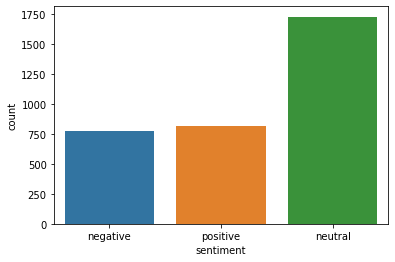

In [82]:
sns.countplot(nca_2017.loc[nca_2017['preds']==5, 'sentiment'])

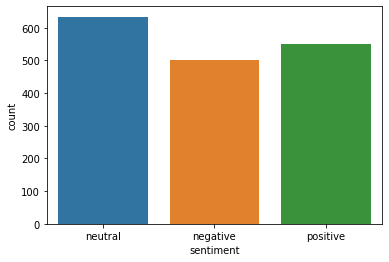

In [83]:
sns.countplot(nca_2017.loc[nca_2017['preds']==0, 'sentiment'])

In [113]:
doc_word, words, id2word, cv_tfidf = tfidf(nca_2017['clean'])

In [114]:
lsa, doc_topic, lsa.explained_variance_ratio_ = dim_lsa(doc_word, 10)

In [115]:
display_topics(lsa, words, 10)


Topic  0
california wildlife, northern california wildlife, northern california, start california wildlife, start california, arrest start, wildlife disrupt, california wildlife disrupt, arrest start california, farm burn california

Topic  1
spread wildlife, spread wildlife people, wildlife today, social medium, wildlife people, watch spread, watch spread wildlife, misinformation spread, spread wildlife social, hope spread wildlife

Topic  2
scotch marijuana, marijuana crop, scotch marijuana crop, wildlife scotch, wildlife scotch marijuana, possibly complicate, marijuana crop possibly, crop possibly complicate, crop possibly, complicate california

Topic  3
vineyards worker, vineyards worker owner, worker owner, wildlife affect, affect vineyards, affect vineyards worker, wildlife affect vineyards, forgive wildlife affect, forgive wildlife, worker owner struggle

Topic  4
wildlife disrupt, school quarter, disrupt school, disrupt school quarter, wildlife disrupt school, quarter million

In [151]:
df_all.fire.unique()

array(['shasta_2018', 'kincade', 'nca_2017', 'sb_2017', 'camp'],
      dtype=object)

In [153]:
doc_word, words, id2word, cv_tfidf = tfidf(df_all.loc[df_all['fire']=='nca_2017', 'clean_tweet'])

In [157]:
lsa, doc_topic, lsa.explained_variance_ratio_ = dim_lsa(doc_word, 5)

In [158]:
display_topics(lsa, words, 30)


Topic  0
death toll, toll rise, death toll rise, california death, california death toll, northern california, mile wide, toll reach, death toll reach, wide death, wide death toll, mile wide death, rise blaze, toll rise blaze, rise california, toll rise california, rise blaze continue, blaze continue, toll climb, death toll climb, california rage, record death toll, record death, rage record, rage record death, california rage record, northern california death, death toll california, toll california, rise firefighter

Topic  1
dog emerge, emerge alive, dog emerge alive, family dog, family dog emerge, alive happy, emerge alive happy, happy aftermath, alive happy aftermath, northern california, alive california, emerge alive california, alive amid, emerge alive amid, alive amid aftermath, amid aftermath, happy california, alive happy california, california aftermath, news family dog, news family, happy california aftermath, dog alive, santa rosa, family dog alive, good dog emerge, good 

## Kincade

In [93]:
with open('data/kincade_5000.pickle', 'rb') as read_file:
    kincade_2019 = pickle.load(read_file)

In [94]:
kincade_2019.head()

,_id,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,fire,sentiment,sent_num,language,spell_trans
0,5dcb3fe31641db7377bbf436,,2019-11-03 00:14,0,0,california fire wildfire utilitie this calif...,,,# # # #,1.19089e+18,https://twitter.com/LuluWalcott1/status/119089...,kincade,neutral,0.000000,en,california fire wildlife utilities this cali...
1,5dcb3fe31641db7377bbf439,,2019-11-03 00:14,0,0,here ’ how state regulator play a role in cali...,,,# # #,1.19089e+18,https://twitter.com/1stAirDel_USMCR/status/119...,kincade,neutral,0.000000,en,here ’ how state regulatory play a role in cal...
2,5dcb3fe31641db7377bbf43a,,2019-11-03 00:13,4,3,remember whentrump offer russia help with sibe...,,,,1.19089e+18,https://twitter.com/SlavicLady88/status/119088...,kincade,negative,-0.266667,en,remember whentrump offer russia help with sibe...
3,5dcb3fe31641db7377bbf43b,,2019-11-03 00:12,0,0,musicfamily giveupsumluv wildfire wildfiresing...,,@ @,# # # #2019 # # #,1.19089e+18,https://twitter.com/RockinWOAPRadio/status/119...,kincade,neutral,0.000000,tl,musicfamily giveupsumluv wildlife wildfiresing...
4,5dcb3fe31641db7377bbf43d,,2019-11-03 00:12,0,0,right all because the -PRON- neighbor be a fir...,,,#,1.19089e+18,https://twitter.com/MJaySFH/status/11908894501...,kincade,positive,0.061905,en,right all because the -PRON- neighbor be a fir...


In [95]:
my_additional_stop_words = ['wildfire', 'like', '-pron-']
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

In [96]:
clean = []
for tweet in kincade_2019['spell_trans']:
    word_tokens = nltk.word_tokenize(str(tweet).lower())
    filtered_sentence = [w for w in word_tokens if w not in stop_words]  
    sentence = ' '.join(filtered_sentence)
    clean.append(sentence)
kincade_2019['clean'] = clean

In [97]:
kincade_2019['bigrams'] = [[gram for gram in nltk.ngrams(tweet.split(), 2)] for tweet in kincade_2019['clean']]

In [98]:
kincade_2019['tokens'] = [tweet.split(' ') for tweet in kincade_2019['clean']]

In [99]:
doc_word, words = count_vec(kincade_2019['clean'])

In [100]:
n_terms = len(words)

In [101]:
n_terms

2446

In [102]:
mgp = gsdmm(kincade_2019['bigrams'], n_terms)

In stage 0: transferred 4060 clusters with 15 clusters populated
In stage 1: transferred 2443 clusters with 15 clusters populated
In stage 2: transferred 2053 clusters with 15 clusters populated
In stage 3: transferred 1908 clusters with 15 clusters populated
In stage 4: transferred 1845 clusters with 15 clusters populated
In stage 5: transferred 1854 clusters with 15 clusters populated
In stage 6: transferred 1815 clusters with 15 clusters populated
In stage 7: transferred 1744 clusters with 15 clusters populated
In stage 8: transferred 1762 clusters with 15 clusters populated
In stage 9: transferred 1741 clusters with 15 clusters populated


In [103]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)
print('*'*20)
# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-15:][::-1]
print('Most important clusters (by number of docs inside):', top_index)
print('*'*20)

Number of documents per topic : [317 282 351 359 283 363 358 341 268 362 345 321 337 368 337]
********************
Most important clusters (by number of docs inside): [13  5  9  3  6  2 10  7 14 12 11  0  4  1  8]
********************


In [104]:
import operator

In [105]:
for i, topic in enumerate(mgp.cluster_word_distribution):
    sorted_x = sorted(topic.items(), key=operator.itemgetter(1), reverse = True)
    print('\n Topic: {}'.format(i))
    print(sorted_x[:20])


 Topic: 0
[(('california', 'wildlife'), 42), (('grow', 'acre'), 16), (('wildlife', 'grow'), 15), (('ca', 'wildlife'), 14), (('new', 'california'), 11), (('burn', 'wildlife'), 11), (('acre', 'overnight'), 10), (('spread', 'wildlife'), 9), (('save', 'home'), 9), (('wildlife', 'season'), 9), (('wildlife', 'california'), 8), (('new', 'normal'), 8), (('los', 'angeles'), 8), (('flood', 'tornado'), 8), (('year', 'wildlife'), 8), (('southern', 'california'), 7), (('gain', 'news'), 7), (('dave', 'ruin'), 7), (('home', 'life'), 7), (('earthquake', 'wildlife'), 7)]

 Topic: 1
[(('wildlife', 'california'), 26), (('california', 'wildlife'), 24), (('climate', 'change'), 20), (('rage', 'wildlife'), 10), (('control', 'wildlife'), 9), (('california', '…'), 9), (('wildlife', 'smoke'), 8), (('natural', 'disaster'), 8), (('destructive', 'wildlife'), 8), (('’', 's'), 7), (('invasion', 'grass'), 6), (('california', 'wildfires'), 6), (('state', 'california'), 6), (('stay', 'safe'), 6), (('need', 'wildlife')

In [106]:
display_gsdmm(mgp, kincade_2019['clean'], 10)

4992
4992

Topic  0
california wildlife, climate change, southern california, wildlife california, los angeles, wildlife burn, great thunder, spread wildlife, wildlife southern, economical breakdown

Topic  4
california wildlife, southern california, wildlife california, spread wildlife, wildlife burn, ca wildlife, climate change, wildlife continue, battle wildlife, wildlife southern

Topic  2

Topic  13


/Users/brittb28/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/brittb28/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [107]:
kincade_2019['preds'] = [mgp.choose_best_label(x)[0] for x in kincade_2019['clean']]

In [110]:
kincade_2019.head()

,_id,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,fire,sentiment,sent_num,language,spell_trans,clean,bigrams,tokens,preds
0,5dcb3fe31641db7377bbf436,,2019-11-03 00:14,0,0,california fire wildfire utilitie this calif...,,,# # # #,1.19089e+18,https://twitter.com/LuluWalcott1/status/119089...,kincade,neutral,0.000000,en,california fire wildlife utilities this cali...,california wildlife utilities california gover...,"[(california, wildlife), (wildlife, utilities)...","[california, wildlife, utilities, california, ...",0
1,5dcb3fe31641db7377bbf439,,2019-11-03 00:14,0,0,here ’ how state regulator play a role in cali...,,,# # #,1.19089e+18,https://twitter.com/1stAirDel_USMCR/status/119...,kincade,neutral,0.000000,en,here ’ how state regulatory play a role in cal...,’ state regulatory play role california ’ s ro...,"[(’, state), (state, regulatory), (regulatory,...","[’, state, regulatory, play, role, california,...",0
2,5dcb3fe31641db7377bbf43a,,2019-11-03 00:13,4,3,remember whentrump offer russia help with sibe...,,,,1.19089e+18,https://twitter.com/SlavicLady88/status/119088...,kincade,negative,-0.266667,en,remember whentrump offer russia help with sibe...,remember whentrump offer russia help siberia w...,"[(remember, whentrump), (whentrump, offer), (o...","[remember, whentrump, offer, russia, help, sib...",0
3,5dcb3fe31641db7377bbf43b,,2019-11-03 00:12,0,0,musicfamily giveupsumluv wildfire wildfiresing...,,@ @,# # # #2019 # # #,1.19089e+18,https://twitter.com/RockinWOAPRadio/status/119...,kincade,neutral,0.000000,tl,musicfamily giveupsumluv wildlife wildfiresing...,musicfamily giveupsumluv wildlife wildfiresing...,"[(musicfamily, giveupsumluv), (giveupsumluv, w...","[musicfamily, giveupsumluv, wildlife, wildfire...",0
4,5dcb3fe31641db7377bbf43d,,2019-11-03 00:12,0,0,right all because the -PRON- neighbor be a fir...,,,#,1.19089e+18,https://twitter.com/MJaySFH/status/11908894501...,kincade,positive,0.061905,en,right all because the -PRON- neighbor be a fir...,right neighbor fireplace freak winter regardle...,"[(right, neighbor), (neighbor, fireplace), (fi...","[right, neighbor, fireplace, freak, winter, re...",0


In [108]:
import seaborn as sns

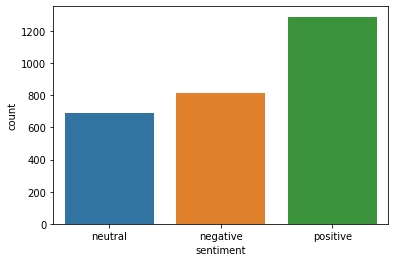

In [111]:
sns.countplot(kincade_2019.loc[kincade_2019['preds']==0, 'sentiment'])

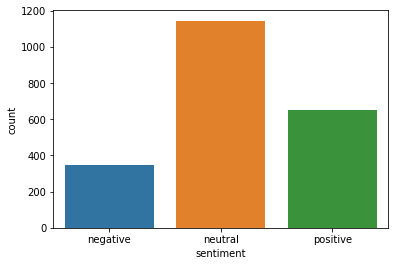

In [112]:
sns.countplot(kincade_2019.loc[kincade_2019['preds']==4, 'sentiment'])

In [143]:
df_all.columns

Index(['_id', 'username', 'date', 'retweets', 'favorites', 'text', 'geo',
       'mentions', 'hashtags', 'id', 'permalink', 'fire', 'clean_tweet',
       'bigrams', 'tokens'],
      dtype='object')

In [144]:
doc_word, words, id2word, cv_tfidf = tfidf(df_all.loc[df_all['fire'] == 'kincade', 'clean_tweet'])

In [147]:
lsa, doc_topic, lsa.explained_variance_ratio_ = dim_lsa(doc_word, 5)

In [148]:
display_topics(lsa, words, 30)


Topic  0
federal aid, federal aid california, aid california, california devastating, devastating continue, vow federal, vow federal aid, aid california devastating, california devastating continue, devastating continue burn, continue burn, trump vow, trump vow federal, burn independent, continue burn independent, trump threaten, climate change, threaten cut, pull federal, pull federal aid, threaten pull, threaten pull federal, trump threaten pull, trump threaten cut, continue burn smartnew, burn smartnew, burn yahoo, continue burn yahoo, cut federal, threaten cut federal

Topic  1
climate change, dereliction duty, california look, hey aoc, government dereliction, hey aoc california, aoc california, duty climate, dereliction duty climate, aoc california look, government dereliction duty, duty climate change, look government dereliction, look government, california look government, turner hey aoc, turner hey, daniel turner, daniel turner hey, change cause, climate change cause, califor

## Comparing 2017 to 2019

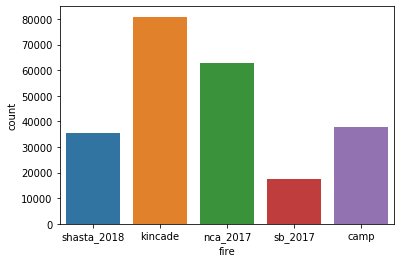

In [161]:
sns.countplot(df_all.fire)

In [160]:
df_all.fire.unique()

array(['shasta_2018', 'kincade', 'nca_2017', 'sb_2017', 'camp'],
      dtype=object)

In [162]:
year = []
for fire in df_all['fire']:
    if fire == 'shasta_2018':
        year.append('2018')
    elif fire == 'kincade':
        year.append('2019')
    elif fire == 'nca_2017':
        year.append('2017')
    elif fire == 'sb_2017':
        year.append('2017')
    else:
        year.append('2018')

In [163]:
df_all['year'] = year

In [166]:
doc_word, words, id2word, cv_tfidf = tfidf(df_all['clean_tweet'])

In [169]:
lsa, doc_topic, lsa.explained_variance_ratio_ = dim_lsa(doc_word, 15)

In [170]:
display_topics(lsa, words, 30)


Topic  0
gender reveal, video gender, video gender reveal, gender reveal cause, reveal cause, cause million, reveal cause million, reveal party, gender reveal party, reveal party ignite, party ignite, release video, release video gender, official release, official release video, reveal party start, party start, ignite cnn, party ignite cnn, baby gender, baby gender reveal, border patrol, party cause, patrol agent, border patrol agent, reveal party cause, idiot video gender, idiot video, reveal party spark, party spark

Topic  1
death toll, toll rise, death toll rise, california death, california death toll, northern california, climate change, toll reach, death toll reach, mile wide, wide death, wide death toll, mile wide death, toll climb, death toll climb, rise blaze, toll rise blaze, rise california, toll rise california, rise blaze continue, blaze continue, death toll california, toll california, california rage, northern california death, record death toll, record death, rage rec

## Clustering by K Means to try and correlate year 

In [176]:
def inertia_plot(X, k_max):
    inertias = []
    for k in range(1,k_max):
        km = KMeans(n_clusters=k)
        km.fit(X)
        inertias.append(km.inertia_)
        plt.scatter(k,km.inertia_, color = 'b')
    plt.plot(range(1,k_max),inertias, color = 'b')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    return plt.show()

In [173]:
def km(X, k):
    km = KMeans(n_clusters=k)
    km.fit(X)
    return 

In [187]:
num_clusters = 3
km = KMeans(n_clusters=num_clusters, init= 'random')
km.fit(doc_topic)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=3,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=None,
       tol=0.0001, verbose=0)

In [188]:
df_all['preds'] = km.predict(doc_topic)

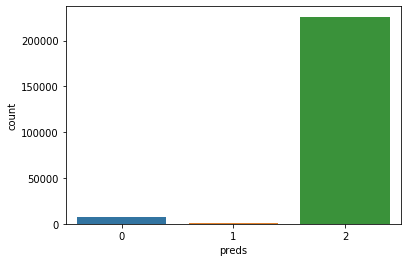

In [189]:
sns.countplot(df_all['preds'])

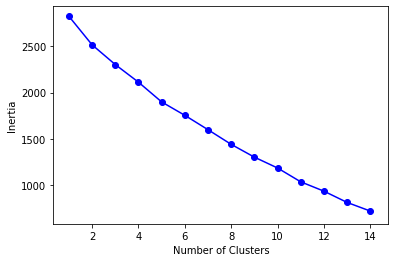

In [177]:
inertia_plot(doc_topic, 15)

In [190]:
doc_word, words = count_vec(df_all['clean_tweet'])

In [191]:
n_terms = len(words)

In [192]:
n_terms

112308

In [193]:
df_all.head()

,_id,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,fire,clean_tweet,bigrams,tokens,year,preds
0,5dcb3fc81641db7377bb1e4e,,2018-09-19 16:59,4802,6465,large wildfire in california history officiall...,,,#,1.04256e+18,https://twitter.com/mdrtindia/status/104256384...,shasta_2018,large california history officially contain,"[(large, california), (california, history), (...","[large, , california, history, officially, con...",2018,2
1,5dcb3fc81641db7377bb1e4f,,2018-09-19 16:59,0,2,have -PRON- see the new nfpa ’s wildfire and f...,,,,1.04256e+18,https://twitter.com/JCFD3FireInfo/status/10425...,shasta_2018,new nfpa firewise usa programs community wes...,"[(new, nfpa), (nfpa, firewise), (firewise, usa...","[, new, nfpa, , firewise, usa, programs, commu...",2018,2
2,5dcb3fc81641db7377bb1e50,,2018-09-19 16:59,7,8,rattlesnake creek fire unofficial wildfire upd...,,,,1.04256e+18,https://twitter.com/FireUnofficial/status/1042...,shasta_2018,rattlesnake creek fire unofficial update acre...,"[(rattlesnake, creek), (creek, fire), (fire, u...","[rattlesnake, creek, fire, unofficial, , updat...",2018,2
3,5dcb3fc81641db7377bb1e51,,2018-09-19 16:57,0,1,wyoming ’s martencreekfire wildfire wyfire wyb...,,,# # # # #,1.04256e+18,https://twitter.com/RSFireNerd/status/10425634...,shasta_2018,wyoming martencreekfire wyfire wybtf intterra,"[(wyoming, martencreekfire), (martencreekfire,...","[wyoming, martencreekfire, , wyfire, wybtf, in...",2018,2
4,5dcb3fc81641db7377bb1e52,,2018-09-19 16:56,0,0,honey cs video for numb drop soon queenhoneyc ...,,@,,1.04256e+18,https://twitter.com/HONEYCOCAINA_/status/10425...,shasta_2018,honey cs video numb drop soon queenhoneyc stre...,"[(honey, cs), (cs, video), (video, numb), (num...","[honey, cs, video, numb, drop, soon, queenhone...",2018,2


In [194]:
mgp = gsdmm(df_all['bigrams'], n_terms)

In stage 0: transferred 192840 clusters with 15 clusters populated
In stage 1: transferred 106530 clusters with 15 clusters populated
In stage 2: transferred 80706 clusters with 15 clusters populated
In stage 3: transferred 71539 clusters with 15 clusters populated
In stage 4: transferred 66452 clusters with 15 clusters populated
In stage 5: transferred 63112 clusters with 15 clusters populated
In stage 6: transferred 60579 clusters with 15 clusters populated
In stage 7: transferred 58387 clusters with 15 clusters populated
In stage 8: transferred 56076 clusters with 15 clusters populated
In stage 9: transferred 54335 clusters with 15 clusters populated


In [195]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)
print('*'*20)
# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-15:][::-1]
print('Most important clusters (by number of docs inside):', top_index)
print('*'*20)

Number of documents per topic : [16309 12552 16236 14396 24905 16572 13496 13419 18337 13770 14059 14605
 12246 16677 16688]
********************
Most important clusters (by number of docs inside): [ 4  8 14 13  5  0  2 11  3 10  9  6  7  1 12]
********************


In [196]:
for i, topic in enumerate(mgp.cluster_word_distribution):
    sorted_x = sorted(topic.items(), key=operator.itemgetter(1), reverse = True)
    print('\n Topic: {}'.format(i))
    print(sorted_x[:20])


 Topic: 0
[(('air', 'quality'), 635), (('stay', 'safe'), 550), (('burn', 'california'), 279), (('bay', 'area'), 270), (('northern', 'california'), 211), (('smoke', 'california'), 185), (('power', 'outage'), 176), (('santa', 'rosa'), 147), (('lose', 'home'), 147), (('climate', 'change'), 145), (('report', 'warn'), 139), (('santa', 'ana'), 133), (('hour', 'pool'), 129), (('survive', 'hour'), 127), (('pool', 'burn'), 126), (('farm', 'burn'), 125), (('ana', 'wind'), 120), (('burn', 'neighborhood'), 120), (('neighborhood', 'ground'), 115), (('smell', 'smoke'), 114)]

 Topic: 1
[(('climate', 'change'), 308), (('acre', 'contain'), 164), (('trump', 'tweet'), 160), (('official', 'safety'), 145), (('safety', 'info'), 145), (('consult', 'official'), 144), (('unofficial', 'update'), 143), (('tweet', 'fatal'), 139), (('wonder', 'trump'), 134), (('californians', 'wonder'), 126), (('los', 'angeles'), 120), (('update', 'acre'), 119), (('northern', 'california'), 119), (('sonoma', 'county'), 116), (('

In [220]:
df_all = df_all.reset_index(drop = True)

In [ ]:
display_gsdmm(df_all['preds'], df_all['clean_tweet'], 10)

234267
234267


/Users/brittb28/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Topic  1
northern california, death toll, climate change, portugal spain, gender reveal, wine country, los angeles, southern california, burn california, california victim


In [201]:
from tqdm import tqdm

In [203]:
preds = []
for tweet in tqdm(df_all['clean_tweet']):
    preds.append(mgp.choose_best_label(tweet)[0])
df_all['preds'] = preds

100%|██████████| 234267/234267 [46:09<00:00, 84.58it/s]    


In [205]:
df_all.preds.unique()

array([ 1,  0, 11,  4, 14])

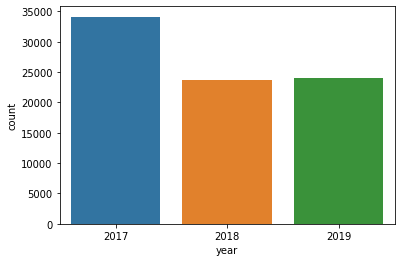

In [210]:
sns.countplot(df_all.loc[df_all['preds']==1, 'year'])

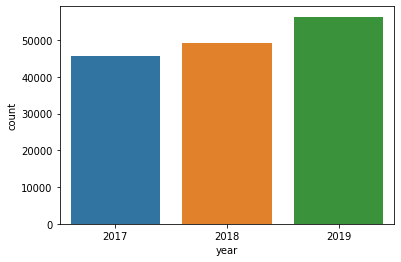

In [211]:
sns.countplot(df_all.loc[df_all['preds']==0, 'year'])

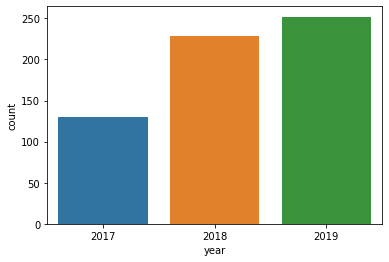

In [212]:
sns.countplot(df_all.loc[df_all['preds']==11, 'year'])

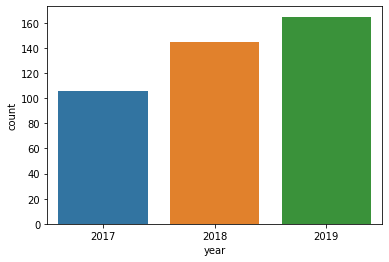

In [214]:
sns.countplot(df_all.loc[df_all['preds']==4, 'year'])

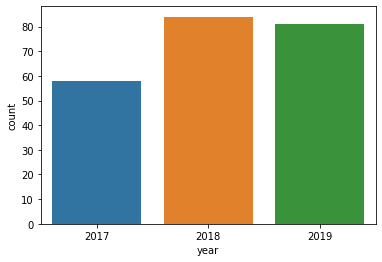

In [215]:
sns.countplot(df_all.loc[df_all['preds']==14, 'year'])